# Uniform (-1, 1) Cl par. 0.1

In [2]:
import argparse
import os
import numpy as np
import math

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch
import shutil
import time

from utils import arg_parser_handler,  show, distribution_select

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Inicializa inputs por meio de notebook (variaveis de classe) ou por terminal (argparse)
args, flag = arg_parser_handler().parser_maker()
if flag == 1:
    args.batch_size=64
    args.n_epochs=10
    args.vae_name = None
    args.dim1 = 256
    args.dim2 = 64
    args.n_paths_G = 10
    args.classifier_para=0.1
    print('No args!')
elif flag == 0:
    print(args)

CUDA = True if torch.cuda.is_available() else False
VAE_FOLDER = 'vae_pretrained/'
IMG_SHAPE = (3, 32, 32)
SHARED_CLASSIFIER = True
DISTRIBUTION = 'uniform'


No args!


usage: ipykernel_launcher.py [-h] [--n_epochs N_EPOCHS]
                             [--batch_size BATCH_SIZE] [--lr LR] [--b1 B1]
                             [--b2 B2] [--n_cpu N_CPU]
                             [--latent_dim LATENT_DIM] [--img_size IMG_SIZE]
                             [--channels CHANNELS]
                             [--sample_interval SAMPLE_INTERVAL]
                             [--n_paths_G N_PATHS_G]
                             [--classifier_para CLASSIFIER_PARA]
                             [--vae_name VAE_NAME] [--dim1 DIM1] [--dim2 DIM2]
                             [--min_size_dataset MIN_SIZE_DATASET]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/corsair/.local/share/jupyter/runtime/kernel-84a7e4f8-40b8-4ed8-91e3-89cf338326fd.json


In [4]:
# Configure data loader
os.makedirs('../data/cifar', exist_ok=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data/cifar', train=True, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([.5],[.5],[.5])
                   ])),
    batch_size=args.batch_size, shuffle=True, drop_last=True)

Tensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor

Files already downloaded and verified


In [5]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [6]:

class Generator(nn.Module):
    def __init__(self, n_paths_G = 2, latent_dim = 100, nz=100, nc = 3, ngf=128):
        super(Generator, self).__init__()
        
        self.n_paths_G = n_paths_G
        self.latent_dim = latent_dim
        
        modules = nn.ModuleList()
        for _ in range(self.n_paths_G):
            modules.append(nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(latent_dim, ngf * 2 * 8 * 8),
            nn.ReLU(True),
            Reshape(-1, ngf * 2, 8, 8),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2,     ngf, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Tanh()
            # output size. (3) x 32 x 32
        ))
            
        self.paths = modules

    def forward(self, z):
        img = []
        
        for path in self.paths:
            img.append(path(z))
        img = torch.cat(img, dim=0)
        return img

In [7]:
'''a, _ = next(iter(dataloader))
a.shape
gen = Generator().cuda()
z = Variable(Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_dim))))
out_gen = gen.paths[0](z)
out_gen.shape'''

'a, _ = next(iter(dataloader))\na.shape\ngen = Generator().cuda()\nz = Variable(Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_dim))))\nout_gen = gen.paths[0](z)\nout_gen.shape'

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=128, n_paths_G = 2, init_sample = None):
        super(Discriminator, self).__init__()
        
        self.n_paths_G = n_paths_G
        self.sigmoid = nn.Sigmoid()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        self.shared = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size=5, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf, momentum = 0.9),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, kernel_size=5, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2, momentum = 0.9),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=5, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4, momentum = 0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        modules = nn.ModuleList()
        modules.append(
            nn.Sequential(

            ))
        modules.append(
            nn.Sequential(

            ))
        
        self.paths = modules
       
        for i, ly in enumerate(self.shared):
            #print(type(ly) == torch.nn.modules.conv.Conv2d)
            if (type(ly) == torch.nn.modules.conv.Conv2d):
                shape = self.shared[:i+1](init_sample).shape
                print('layer: {}'.format(i))
                print(ly)
                print('output shape: {}'.format(shape))
                
        for i, ly in enumerate(self.paths[0]):
            #print(type(ly) == torch.nn.modules.conv.Conv2d)
            if (type(ly) == torch.nn.modules.conv.Conv2d):
                shape =  self.paths[0][:i+1](self.shared(init_sample)).shape
                print('layer: {}'.format(i))
                print(ly)
                print('output shape: {}'.format(shape))
                
        total_units = self.paths[0](self.shared(init_sample)).view(args.batch_size, -1).shape[-1]
        print("Total Units : {}".format(total_units))
        
        self.linear_disc  = nn.Linear(total_units, 1)
        self.linear_class = nn.Linear(total_units, n_paths_G)
        
    def forward(self, img):
            
        shared_output = self.shared(img)
        validity = (self.paths[0](shared_output)).view(img.shape[0], -1)
        validity = self.sigmoid(self.linear_disc(validity))
        
        classification = (self.paths[1](shared_output)).view(img.shape[0], -1)
        classification = self.linear_class(classification)
        classification = self.log_softmax(classification)
        
        #validity = (self.paths[0](shared_output)).view(-1, 1)
        #classifier = (self.paths[1](shared_output)).view(-1, self.n_paths_G).squeeze(1)
        
        return validity, classification
    
    

In [9]:
'''out_gen.shape

init_tensor = torch.zeros(args.batch_size,3,32,32)

disc = Discriminator(init_sample = init_tensor, n_paths_G=args.n_paths_G).cuda()
out_disc = disc(out_gen)
out_disc[0].shape

out_disc[1].shape

args.n_paths_G'''

'out_gen.shape\n\ninit_tensor = torch.zeros(args.batch_size,3,32,32)\n\ndisc = Discriminator(init_sample = init_tensor, n_paths_G=args.n_paths_G).cuda()\nout_disc = disc(out_gen)\nout_disc[0].shape\n\nout_disc[1].shape\n\nargs.n_paths_G'

In [10]:
'''out_disc[0].shape

valid = Variable(Tensor(100, 1).fill_(1.0), requires_grad=False)

valid.shape

z = Variable(Tensor(np.random.normal(0, 1, (100, 100))))

gen_imgs = gen.paths[0](z)

validity, classification = disc(gen_imgs)
# Loss measures generator's ability to fool the discriminator



target = Variable(Tensor(100).fill_(1), requires_grad=False)
target = target.type(torch.cuda.LongTensor)



F.nll_loss(classification, target)


adversarial_loss(validity, valid)'''

"out_disc[0].shape\n\nvalid = Variable(Tensor(100, 1).fill_(1.0), requires_grad=False)\n\nvalid.shape\n\nz = Variable(Tensor(np.random.normal(0, 1, (100, 100))))\n\ngen_imgs = gen.paths[0](z)\n\nvalidity, classification = disc(gen_imgs)\n# Loss measures generator's ability to fool the discriminator\n\n\n\ntarget = Variable(Tensor(100).fill_(1), requires_grad=False)\ntarget = target.type(torch.cuda.LongTensor)\n\n\n\nF.nll_loss(classification, target)\n\n\nadversarial_loss(validity, valid)"

In [11]:
def generators_confusion_matrix(generator, discriminator, samples = 100):

    generator.eval()
    discriminator.eval()
    acc_all_gens = np.zeros((args.n_paths_G, args.n_paths_G))
    temp = []

    for s in range(samples):
        z = Variable(Tensor(distribution_select(DISTRIBUTION, (args.batch_size, args.latent_dim))))
        for k in range(args.n_paths_G):

            # Generate a batch of images
            gen_imgs = generator.paths[k](z)

            # Loss measures generator's ability to fool the discriminator

            validity, classification = discriminator(gen_imgs)
            # Loss measures classifier's ability }to classify various generators

            target = Variable(Tensor(args.batch_size).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)

            acc_gen_k = []

            for target in range(args.n_paths_G):
                acc = ((classification.argmax(dim=1))==target).sum().cpu().numpy()/args.batch_size
                acc_gen_k.append(acc)

            acc_all_gens[k] = (np.array(acc_all_gens[k]) + np.array(acc_gen_k))
            torch.cuda.empty_cache()

    return acc_all_gens/samples

def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix)
    plt.figure(figsize = (10,8))
    sn.heatmap(df_cm, annot=True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.xlabel('RESPOSTA DO CLASSIFICADOR')
    plt.ylabel('IMAGENS DE CADA GERADOR')
    plt.show() # ta-da!


In [44]:
def train_models(dataloader, generator, discriminator,
                 adversarial_loss, optimizer_D, optimizer_G, 
                 classifier = None, optimizer_C = None, show_logs = False):
        
    for epoch in tqdm_notebook(range(args.n_epochs)):

        start = time.time()
        epoch_start = 0
        g_loss_epoch = 0
        d_loss_epoch = 0
        c_loss_1_epoch = 0
        c_loss_2_epoch = 0
        num_batches = len(dataloader)
        
        generator.train()
        discriminator.train()
        (imgs, _ ) = next(iter(dataloader))
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        all_labels = []
        for k in range(args.n_paths_G):
            all_labels.append(Tensor([k]*imgs.shape[0]))
            
        all_labels = torch.cat(all_labels, dim=0).type(torch.cuda.LongTensor)
        
        for i, (imgs, _) in enumerate(dataloader):
            
            # Sample noise as generator input
            z = Variable(Tensor(distribution_select(DISTRIBUTION, (args.batch_size, args.latent_dim))))
        
            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ------------------------------------
            #  Train Discriminator and Classifier
            # ------------------------------------

            optimizer_D.zero_grad()

            d_loss = 0
            c_loss_1 = 0
            
            validity, classification = discriminator(real_imgs)
            real_loss = adversarial_loss(validity, valid)
            d_loss += real_loss
            plot_imgs = []
            all_imgs = []
            
            for k in range(args.n_paths_G):

                # Generate a batch of images
                gen_imgs = generator.paths[k](z).view(imgs.shape[0], *IMG_SHAPE)
                all_imgs.append(gen_imgs)
                plot_imgs.append(gen_imgs[0:20, :])
                
            all_imgs = torch.cat(all_imgs, dim=0)
            
            validity, classification = discriminator(all_imgs.detach())

            fake_loss = adversarial_loss(validity, fake.repeat(args.n_paths_G,1))
            d_loss += fake_loss

            # Loss measures classifier's ability to classify various generators
            c_loss_1 += F.nll_loss(classification, all_labels)*args.classifier_para

            plot_imgs = torch.cat(plot_imgs, dim=0)

            d_loss_epoch += d_loss
            c_loss_1_epoch += c_loss_1
            
            d_loss = d_loss + c_loss_1
            d_loss.backward()
            optimizer_D.step()
                
            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()
        
            g_loss = 0
            c_loss_2 = 0
            all_imgs = []
            
            gen_sequence1 = np.arange(args.n_paths_G)
            np.random.shuffle(gen_sequence1)
            
            for k in range(args.n_paths_G):

                # Generate a batch of images
                gen_imgs = generator.paths[k](z).view(imgs.shape[0], *IMG_SHAPE)
                all_imgs.append(gen_imgs)
                
            all_imgs = torch.cat(all_imgs, dim=0)

            validity, classification = discriminator(all_imgs)

            g_loss += adversarial_loss(validity, valid.repeat(args.n_paths_G, 1))
            
            c_loss_2 += F.nll_loss(classification, all_labels)*args.classifier_para

            g_loss_epoch += g_loss
            c_loss_2_epoch += c_loss_2

            g_loss = g_loss + c_loss_2
            g_loss.backward()
            optimizer_G.step()

            batches_done = epoch * len(dataloader) + i

        interval = time.time() - start

        if epoch % (args.n_epochs//5) == 0 and show_logs:

            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] \t Time Interv: %f"
                   % (epoch, args.n_epochs, i, num_batches, d_loss_epoch/num_batches, g_loss_epoch/num_batches, 
                      c_loss_1_epoch/num_batches, c_loss_2_epoch/num_batches, interval))
            #print(gen_sequence1)
            #print(gen_sequence2)
            show(make_grid(plot_imgs.cpu(), nrow=20, normalize=True), 20)
            plot_confusion_matrix(generators_confusion_matrix(generator, discriminator))
            plt.show()

In [45]:
init_tensor = torch.zeros(args.batch_size,3,32,32)

In [46]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

layer: 0
Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
output shape: torch.Size([64, 128, 15, 15])
layer: 3
Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
output shape: torch.Size([64, 256, 7, 7])
layer: 6
Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
output shape: torch.Size([64, 512, 3, 3])
Total Units : 4608


/home/corsair/.conda/envs/torch_gan/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


[Epoch 0/10] [Batch 780/781] [D loss: 0.276264] [G loss: 4.433975] [C loss 1: 0.006738] [C loss 2: 0.004478] 	 Time Interv: 206.765240


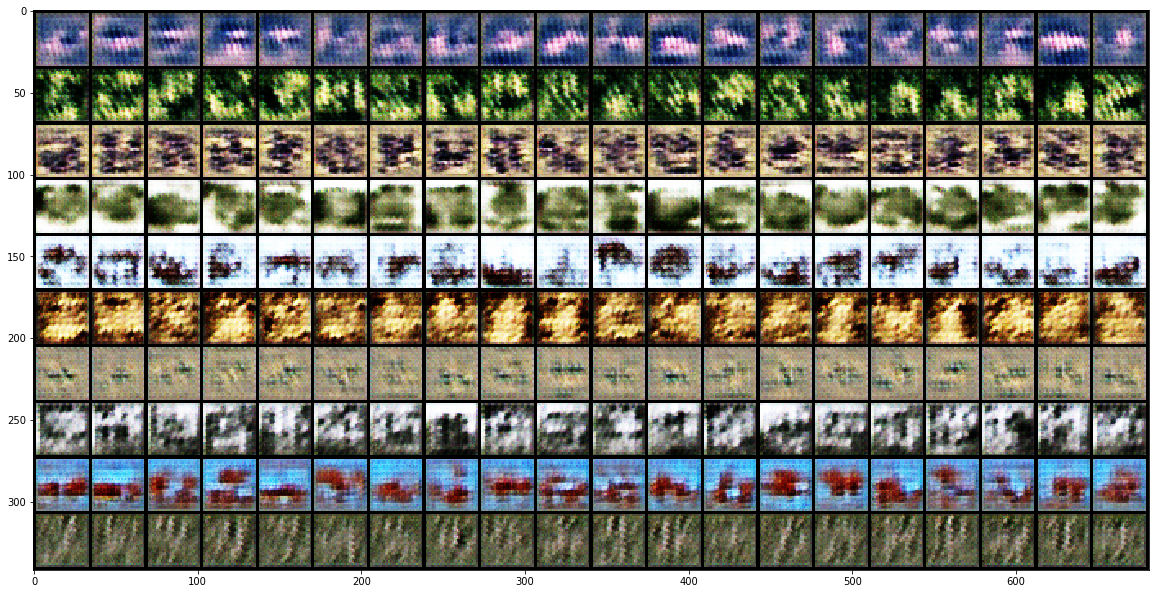

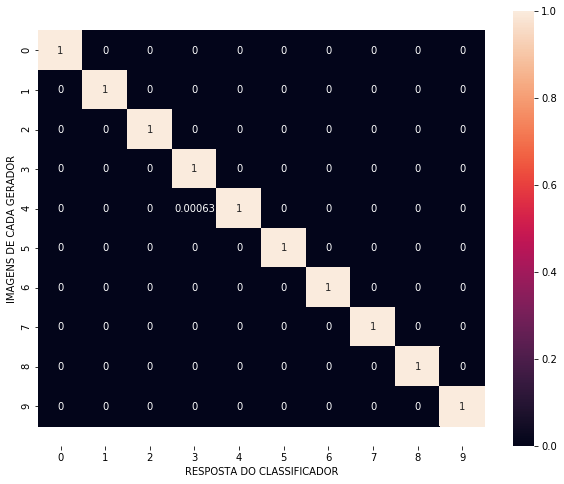

KeyboardInterrupt: 

In [47]:
branch_counter = 0
gen_stack= []
disc_stack =[]
data_loader_stack = []

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

generator = Generator(n_paths_G=args.n_paths_G)  
discriminator = Discriminator(n_paths_G=args.n_paths_G, init_sample=init_tensor)
        
if CUDA:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr1, betas=(args.b1, args.b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr2, betas=(args.b1, args.b2))
print('TRAIN 1')
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)



In [ ]:
print('TRAIN 2')
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)



In [ ]:
print('TRAIN 3')
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)


In [ ]:
print('TRAIN 4')
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)


In [ ]:
import sys 

sys.modules[__name__].__dict__.clear()
import torch
torch.cuda.empty_cache()